# Part 1: data preparation

In [6]:
import pandas as pd
from google.colab import drive
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

train_df = pd.read_csv('train_data.csv')
superclass_map = pd.read_csv('superclass_mapping.csv')
subclass_map = pd.read_csv('subclass_mapping.csv')

superclass_to_idx = dict(zip(superclass_map['class'], superclass_map['index']))
idx_to_superclass = dict(zip(superclass_map['index'], superclass_map['class']))
subclass_to_idx = dict(zip(subclass_map['class'], subclass_map['index']))
idx_to_subclass = dict(zip(subclass_map['index'], subclass_map['class']))

drive.mount('/content/drive')
train_img_dir = '/content/drive/My Drive/NNDL/train_images'
!cp -r "/content/drive/My Drive/NNDL/train_images" /content/
train_img_dir = "/content/train_images"

def get_transforms():
    return transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


class TransferLearningDataset(Dataset):
    def __init__(self, ann_df, super_map_df, sub_map_df, img_dir, transform=None):
        self.ann_df = ann_df.reset_index(drop=True)
        self.super_map_df = super_map_df
        self.sub_map_df = sub_map_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.ann_df)

    def __getitem__(self, idx):
        row = self.ann_df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, row['superclass_index'], self.super_map_df.loc[self.super_map_df['index'] == row['superclass_index'], 'class'].values[0], row['subclass_index'], self.sub_map_df.loc[self.sub_map_df['index'] == row['subclass_index'], 'class'].values[0]

image_preprocessing = get_transforms()

full_dataset = TransferLearningDataset(train_df, superclass_map, subclass_map, train_img_dir, transform=image_preprocessing)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
seen_superclass_indices = set(train_df['superclass_index'].unique())
seen_subclass_indices = set(train_df['subclass_index'].unique())



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Checking for imbalance

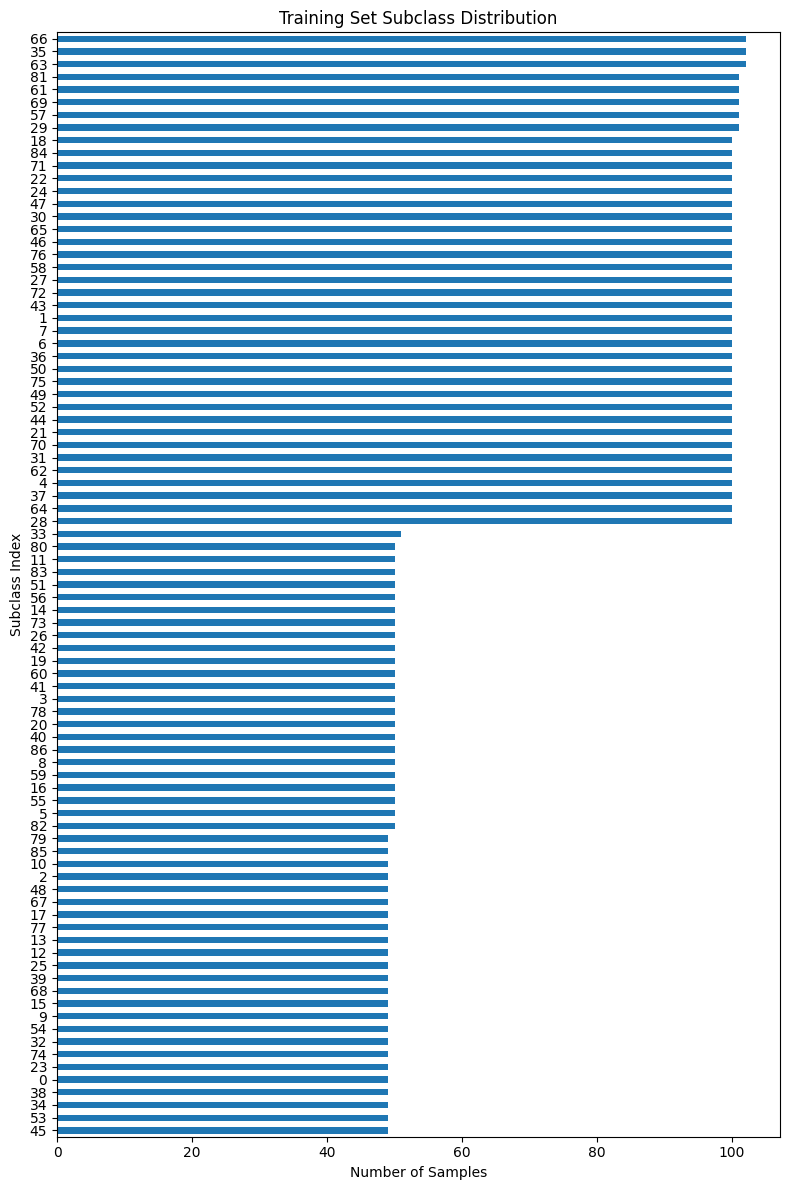

In [ ]:
import matplotlib.pyplot as plt

train_df['subclass_index'].value_counts().sort_values().plot(kind='barh', figsize=(8, 12))
plt.xlabel("Number of Samples")
plt.ylabel("Subclass Index")
plt.title("Training Set Subclass Distribution")
plt.tight_layout()
plt.show()

Image batch shape: torch.Size([64, 3, 64, 64])
Superclass indices: tensor([1, 2, 0, 2, 0])
Superclass labels: ('dog', 'reptile', 'bird', 'reptile', 'bird')
Subclass indices: tensor([53, 50, 28, 69, 11])
Subclass labels: ('soft-coated wheaten terrier', 'European fire salamander, Salamandra salamandra', 'black grouse', 'tree frog, tree-frog', 'pelican')


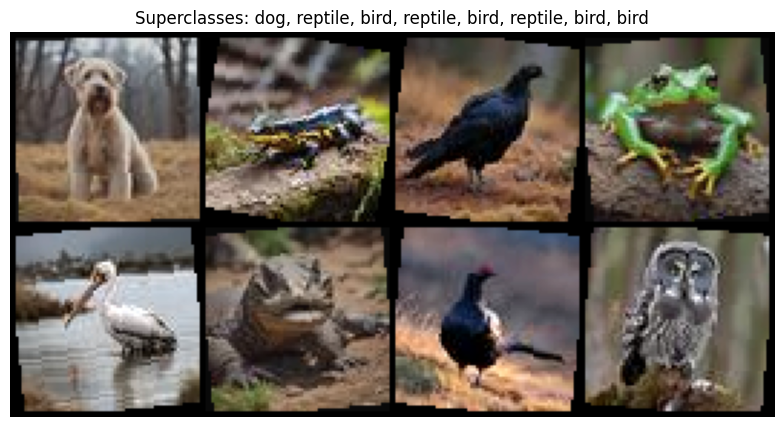

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision

images, super_idx, super_lbl, sub_idx, sub_lbl = next(iter(train_loader))

print("Image batch shape:", images.shape)
print("Superclass indices:", super_idx[:5])
print("Superclass labels:", super_lbl[:5])
print("Subclass indices:", sub_idx[:5])
print("Subclass labels:", sub_lbl[:5])

def unnormalize(img_tensor):
    return img_tensor * 0.5 + 0.5

unnormalized_imgs = [unnormalize(img.clone()) for img in images[:8]]
unnormalized_imgs = torch.stack(unnormalized_imgs)

grid = torchvision.utils.make_grid(unnormalized_imgs, nrow=4)
plt.figure(figsize=(10, 5))
plt.imshow(grid.permute(1, 2, 0))
plt.title("Superclasses: " + ", ".join(super_lbl[:8]))
plt.axis('off')
plt.show()

# Part 2: Model Architectures

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()


class CNNBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_size = 64 // 8
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(self.feature_size**2 * 128, 256)
        self.fc2 = nn.Linear(256, 128)
        self.super_head = nn.Linear(128, 4)
        self.sub_head = nn.Linear(128, 88)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.super_head(x), self.sub_head(x)

class ResNetDualHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.shared_fc = nn.Linear(512, 256)
        self.super_head = nn.Linear(256, 4)
        self.sub_head = nn.Linear(256, 88)

    def forward(self, x):
        x = self.backbone(x)
        x = F.relu(self.shared_fc(x))
        return self.super_head(x), self.sub_head(x)

class EfficientNetDualHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)
        self.backbone.classifier = nn.Identity()
        self.shared_fc = nn.Linear(1280, 256)
        self.super_head = nn.Linear(256, 4)
        self.sub_head = nn.Linear(256, 88)

    def forward(self, x):
        x = self.backbone(x)
        x = F.relu(self.shared_fc(x))
        return self.super_head(x), self.sub_head(x)

def get_model(name, fine_tune_strategy='full'):
    if name == 'cnn':
        return CNNBaseline().to(device)
    elif name == 'resnet18':
        model = ResNetDualHead()
        if fine_tune_strategy == 'linear':
            for param in model.backbone.parameters():
                param.requires_grad = False
        elif fine_tune_strategy == 'partial':
            for name, param in model.backbone.named_parameters():
                param.requires_grad = 'layer4' in name or 'fc' in name
        return model.to(device)
    elif name == 'efficientnet':
        model = EfficientNetDualHead()
        if fine_tune_strategy == 'linear':
            for param in model.backbone.parameters():
                param.requires_grad = False
        elif fine_tune_strategy == 'partial':
            for name, param in model.backbone.named_parameters():
                param.requires_grad = 'features.6' in name or 'features.7' in name
        return model.to(device)
    else:
        raise ValueError("Unknown model name")

import torch.optim as optim

def mixup_data(x, y1, y2, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = torch._sample_dirichlet(torch.tensor([alpha, alpha])).tolist()[0]
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y1_a, y1_b = y1, y1[index]
    y2_a, y2_b = y2, y2[index]
    return mixed_x, y1_a, y1_b, y2_a, y2_b, lam



# Part 3: Training

In [ ]:


def train_epoch(model, loader, optimizer, criterion, device, mixup_alpha=1.0):
    model.train()
    total_loss = 0

    for batch_idx, (images, y_super, _, y_sub, _) in enumerate(loader):
        images, y_super, y_sub = images.to(device), y_super.to(device), y_sub.to(device)

        # Apply Mixup
        images, y_super_a, y_super_b, y_sub_a, y_sub_b, lam = mixup_data(images, y_super, y_sub, alpha=mixup_alpha)

        optimizer.zero_grad()
        pred_super, pred_sub = model(images)

        # Mixup Loss
        loss_super = lam * criterion(pred_super, y_super_a) + (1 - lam) * criterion(pred_super, y_super_b)
        loss_sub = lam * criterion(pred_sub, y_sub_a) + (1 - lam) * criterion(pred_sub, y_sub_b)
        loss = loss_super + loss_sub

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"[Batch {batch_idx}/{len(loader)}] Loss: {loss.item():.4f}")

    return total_loss / len(loader)


def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total = 0
    super_correct = 0
    sub_correct = 0
    with torch.no_grad():
        for images, y_super, _, y_sub, _ in loader:
            images, y_super, y_sub = images.to(device), y_super.to(device), y_sub.to(device)
            pred_super, pred_sub = model(images)
            loss = criterion(pred_super, y_super) + criterion(pred_sub, y_sub)
            total_loss += loss.item()
            super_correct += (pred_super.argmax(1) == y_super).sum().item()
            sub_correct += (pred_sub.argmax(1) == y_sub).sum().item()
            total += y_super.size(0)
    return total_loss / len(loader), 100 * super_correct / total, 100 * sub_correct / total

def validate_seen_vs_novel(model, loader, criterion, device):
    model.eval()
    total_seen_super = total_novel_super = correct_seen_super = correct_novel_super = 0
    total_seen_sub = total_novel_sub = correct_seen_sub = correct_novel_sub = 0

    with torch.no_grad():
        for images, y_super, _, y_sub, _ in loader:
            images, y_super, y_sub = images.to(device), y_super.to(device), y_sub.to(device)
            pred_super, pred_sub = model(images)
            pred_super_cls = pred_super.argmax(dim=1)
            pred_sub_cls = pred_sub.argmax(dim=1)

            for i in range(len(images)):
                super_idx = y_super[i].item()
                sub_idx = y_sub[i].item()

                if super_idx in seen_superclass_indices:
                    total_seen_super += 1
                    if pred_super_cls[i].item() == super_idx:
                        correct_seen_super += 1
                else:
                    total_novel_super += 1
                    if pred_super_cls[i].item() == super_idx:
                        correct_novel_super += 1

                if sub_idx in seen_subclass_indices:
                    total_seen_sub += 1
                    if pred_sub_cls[i].item() == sub_idx:
                        correct_seen_sub += 1
                else:
                    total_novel_sub += 1
                    if pred_sub_cls[i].item() == sub_idx:
                        correct_novel_sub += 1

    result = {
        "Seen Superclass Accuracy": 100 * correct_seen_super / total_seen_super if total_seen_super > 0 else 0.0,
        "Novel Superclass Accuracy": 100 * correct_novel_super / total_novel_super if total_novel_super > 0 else 0.0,
        "Seen Subclass Accuracy": 100 * correct_seen_sub / total_seen_sub if total_seen_sub > 0 else 0.0,
        "Novel Subclass Accuracy": 100 * correct_novel_sub / total_novel_sub if total_novel_sub > 0 else 0.0
    }

    print(" Seen vs Novel Accuracy Report:")
    for k, v in result.items():
        print(f"{k}: {v:.2f}%")
    return result


def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, super_acc, sub_acc = validate_epoch(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Super Acc: {super_acc:.2f}% | Sub Acc: {sub_acc:.2f}%")

def get_finetuning_params(model, strategy):
    if strategy == 'full':
        for p in model.backbone.parameters(): p.requires_grad = True
    elif strategy == 'linear':
        for p in model.backbone.parameters(): p.requires_grad = False
    elif strategy == 'partial':
        for name, p in model.backbone.named_parameters():
            p.requires_grad = 'layer4' in name or 'features.6' in name or 'features.7' in name
    return filter(lambda p: p.requires_grad, model.parameters())

def run_training(model_name, model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    print(f"\n Training model: {model_name}")
    history = {
        'train_loss': [],
        'val_loss': [],
        'super_acc': [],
        'sub_acc': []
    }

    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, super_acc, sub_acc = validate_epoch(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Super Acc: {super_acc:.2f}% | Sub Acc: {sub_acc:.2f}%")

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['super_acc'].append(super_acc)
        history['sub_acc'].append(sub_acc)

    return history

In [ ]:
cnn_model = get_model('cnn')
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4, weight_decay=1e-4)

cnn_history = run_training(
    model_name="CNN Baseline",
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=cnn_optimizer,
    device=device,
    epochs=10,
)
torch.save(cnn_model.state_dict(), "cnn_full_best_model.pt")
validate_seen_vs_novel(cnn_model, val_loader, nn.CrossEntropyLoss(), device)


 Training model: CNN Baseline
[Batch 0/89] Loss: 5.9035
[Batch 10/89] Loss: 5.4303
[Batch 20/89] Loss: 5.0947
[Batch 30/89] Loss: 5.0367
[Batch 40/89] Loss: 4.8664
[Batch 50/89] Loss: 4.8235
[Batch 60/89] Loss: 4.9516
[Batch 70/89] Loss: 4.9421
[Batch 80/89] Loss: 4.4676
Epoch 1/10 | Train Loss: 4.9697 | Val Loss: 3.8649 | Super Acc: 92.21% | Sub Acc: 20.83%
[Batch 0/89] Loss: 4.6485
[Batch 10/89] Loss: 4.5718
[Batch 20/89] Loss: 4.1282
[Batch 30/89] Loss: 4.5230
[Batch 40/89] Loss: 4.3761
[Batch 50/89] Loss: 4.4115
[Batch 60/89] Loss: 3.8622
[Batch 70/89] Loss: 4.4169
[Batch 80/89] Loss: 3.6291
Epoch 2/10 | Train Loss: 4.1263 | Val Loss: 2.7324 | Super Acc: 95.87% | Sub Acc: 40.38%
[Batch 0/89] Loss: 4.1262
[Batch 10/89] Loss: 4.0120
[Batch 20/89] Loss: 3.6198
[Batch 30/89] Loss: 3.1008
[Batch 40/89] Loss: 3.3919
[Batch 50/89] Loss: 3.6050
[Batch 60/89] Loss: 2.4691
[Batch 70/89] Loss: 2.7875
[Batch 80/89] Loss: 3.7161
Epoch 3/10 | Train Loss: 3.4385 | Val Loss: 2.0889 | Super Acc: 9

{'Seen Superclass Accuracy': 97.61526232114467,
 'Novel Superclass Accuracy': 0.0,
 'Seen Subclass Accuracy': 74.08585055643879,
 'Novel Subclass Accuracy': 0.0}

In [ ]:
resnet_linear = get_model('resnet18', fine_tune_strategy='linear')
resnet_linear_optimizer = optim.Adam(get_finetuning_params(resnet_linear, 'linear'), lr=1e-4, weight_decay=1e-4)

resnet_linear_history = run_training(
    model_name="ResNet18 - Linear",
    model=resnet_linear,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=resnet_linear_optimizer,
    device=device,
    epochs=10
)
torch.save(resnet_linear.state_dict(), "resnet18_linear_best_model.pt")
validate_seen_vs_novel(resnet_linear, val_loader, nn.CrossEntropyLoss(), device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]



 Training model: ResNet18 - Linear
[Batch 0/89] Loss: 5.9559
[Batch 10/89] Loss: 5.6284
[Batch 20/89] Loss: 5.4876
[Batch 30/89] Loss: 5.4873
[Batch 40/89] Loss: 5.3643
[Batch 50/89] Loss: 5.5275
[Batch 60/89] Loss: 5.2755
[Batch 70/89] Loss: 5.3704
[Batch 80/89] Loss: 5.2953
Epoch 1/10 | Train Loss: 5.4521 | Val Loss: 4.9941 | Super Acc: 78.38% | Sub Acc: 5.56%
[Batch 0/89] Loss: 5.2936
[Batch 10/89] Loss: 5.2261
[Batch 20/89] Loss: 4.9240
[Batch 30/89] Loss: 4.9042
[Batch 40/89] Loss: 4.8040
[Batch 50/89] Loss: 4.6868
[Batch 60/89] Loss: 5.3241
[Batch 70/89] Loss: 4.7654
[Batch 80/89] Loss: 4.8848
Epoch 2/10 | Train Loss: 5.0825 | Val Loss: 4.5147 | Super Acc: 83.47% | Sub Acc: 13.20%
[Batch 0/89] Loss: 4.6797
[Batch 10/89] Loss: 4.6663
[Batch 20/89] Loss: 4.7412
[Batch 30/89] Loss: 4.9552
[Batch 40/89] Loss: 4.5882
[Batch 50/89] Loss: 4.8944
[Batch 60/89] Loss: 5.1387
[Batch 70/89] Loss: 4.6319
[Batch 80/89] Loss: 4.3398
Epoch 3/10 | Train Loss: 4.8503 | Val Loss: 4.1535 | Super Ac

{'Seen Superclass Accuracy': 89.66613672496025,
 'Novel Superclass Accuracy': 0.0,
 'Seen Subclass Accuracy': 39.58664546899841,
 'Novel Subclass Accuracy': 0.0}

In [ ]:
resnet_partial = get_model('resnet18', fine_tune_strategy='partial')
resnet_partial_optimizer = optim.Adam(get_finetuning_params(resnet_partial, 'partial'), lr=1e-4, weight_decay=1e-4)

resnet_partial_history = run_training(
    model_name="ResNet18 - Partial FT",
    model=resnet_partial,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=resnet_partial_optimizer,
    device=device,
    epochs=10

)
torch.save(resnet_partial.state_dict(), "resnet18_partial_best_model.pt")
validate_seen_vs_novel(resnet_partial, val_loader, nn.CrossEntropyLoss(), device)


 Training model: ResNet18 - Partial FT
[Batch 0/89] Loss: 6.1565
[Batch 10/89] Loss: 5.5461
[Batch 20/89] Loss: 5.1853
[Batch 30/89] Loss: 5.0207
[Batch 40/89] Loss: 5.0077
[Batch 50/89] Loss: 4.8603
[Batch 60/89] Loss: 4.8656
[Batch 70/89] Loss: 4.8655
[Batch 80/89] Loss: 4.9053
Epoch 1/10 | Train Loss: 4.9688 | Val Loss: 3.5716 | Super Acc: 94.91% | Sub Acc: 27.19%
[Batch 0/89] Loss: 4.0675
[Batch 10/89] Loss: 4.2448
[Batch 20/89] Loss: 3.8947
[Batch 30/89] Loss: 4.3989
[Batch 40/89] Loss: 4.1847
[Batch 50/89] Loss: 4.3918
[Batch 60/89] Loss: 4.1839
[Batch 70/89] Loss: 3.4092
[Batch 80/89] Loss: 4.3540
Epoch 2/10 | Train Loss: 4.0864 | Val Loss: 2.4862 | Super Acc: 98.09% | Sub Acc: 47.85%
[Batch 0/89] Loss: 2.6415
[Batch 10/89] Loss: 3.6814
[Batch 20/89] Loss: 2.3192
[Batch 30/89] Loss: 2.7702
[Batch 40/89] Loss: 3.3178
[Batch 50/89] Loss: 2.5550
[Batch 60/89] Loss: 3.3595
[Batch 70/89] Loss: 3.2002
[Batch 80/89] Loss: 3.4493
Epoch 3/10 | Train Loss: 3.4383 | Val Loss: 1.8977 | Sup

{'Seen Superclass Accuracy': 98.72813990461049,
 'Novel Superclass Accuracy': 0.0,
 'Seen Subclass Accuracy': 79.3322734499205,
 'Novel Subclass Accuracy': 0.0}

In [ ]:
resnet_full = get_model('resnet18', fine_tune_strategy='full')
resnet_full_optimizer = optim.Adam(get_finetuning_params(resnet_full, 'full'), lr=1e-4, weight_decay=1e-4)

resnet_full_history = run_training(
    model_name="ResNet18 - Full FT",
    model=resnet_full,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=resnet_full_optimizer,
    device=device,
    epochs=10

)
torch.save(resnet_full.state_dict(), "resnet18_full_best_model.pt")
validate_seen_vs_novel(resnet_full, val_loader, nn.CrossEntropyLoss(), device)


 Training model: ResNet18 - Full FT
[Batch 0/89] Loss: 5.8816
[Batch 10/89] Loss: 5.4827
[Batch 20/89] Loss: 5.3525
[Batch 30/89] Loss: 5.1234
[Batch 40/89] Loss: 4.4441
[Batch 50/89] Loss: 4.8385
[Batch 60/89] Loss: 4.6115
[Batch 70/89] Loss: 4.4544
[Batch 80/89] Loss: 3.7791
Epoch 1/10 | Train Loss: 4.7790 | Val Loss: 2.9777 | Super Acc: 98.09% | Sub Acc: 37.68%
[Batch 0/89] Loss: 4.4646
[Batch 10/89] Loss: 4.3852
[Batch 20/89] Loss: 3.9576
[Batch 30/89] Loss: 3.5285
[Batch 40/89] Loss: 4.1398
[Batch 50/89] Loss: 2.7137
[Batch 60/89] Loss: 4.5555
[Batch 70/89] Loss: 3.4444
[Batch 80/89] Loss: 2.0465
Epoch 2/10 | Train Loss: 3.4920 | Val Loss: 1.7699 | Super Acc: 99.05% | Sub Acc: 66.14%
[Batch 0/89] Loss: 3.9178
[Batch 10/89] Loss: 3.7735
[Batch 20/89] Loss: 1.9184
[Batch 30/89] Loss: 2.9402
[Batch 40/89] Loss: 2.9156
[Batch 50/89] Loss: 1.9071
[Batch 60/89] Loss: 3.7408
[Batch 70/89] Loss: 1.8182
[Batch 80/89] Loss: 1.4724
Epoch 3/10 | Train Loss: 2.7645 | Val Loss: 1.1103 | Super 

{'Seen Superclass Accuracy': 99.04610492845786,
 'Novel Superclass Accuracy': 0.0,
 'Seen Subclass Accuracy': 89.1891891891892,
 'Novel Subclass Accuracy': 0.0}

In [ ]:
efficientnet_linear = get_model('efficientnet', fine_tune_strategy='linear')
efficientnet_linear_optimizer = optim.Adam(get_finetuning_params(efficientnet_linear, 'linear'), lr=1e-4, weight_decay=1e-4)

efficientnet_linear_history = run_training(
    model_name="EfficientNet - Linear",
    model=efficientnet_linear,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=efficientnet_linear_optimizer,
    device=device,
    epochs=10
)
torch.save(efficientnet_linear.state_dict(), "efficientnet_linear_best_model.pt")
validate_seen_vs_novel(efficientnet_linear, val_loader, nn.CrossEntropyLoss(), device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 191MB/s]



 Training model: EfficientNet - Linear
[Batch 0/89] Loss: 5.8501
[Batch 10/89] Loss: 5.7713
[Batch 20/89] Loss: 5.6358
[Batch 30/89] Loss: 5.6093
[Batch 40/89] Loss: 5.4848
[Batch 50/89] Loss: 5.4160
[Batch 60/89] Loss: 5.5027
[Batch 70/89] Loss: 5.2598
[Batch 80/89] Loss: 5.2611
Epoch 1/10 | Train Loss: 5.5268 | Val Loss: 5.1859 | Super Acc: 80.29% | Sub Acc: 3.82%
[Batch 0/89] Loss: 5.1813
[Batch 10/89] Loss: 5.3640
[Batch 20/89] Loss: 5.1711
[Batch 30/89] Loss: 5.2869
[Batch 40/89] Loss: 5.2529
[Batch 50/89] Loss: 5.0779
[Batch 60/89] Loss: 5.1784
[Batch 70/89] Loss: 5.0364
[Batch 80/89] Loss: 5.0996
Epoch 2/10 | Train Loss: 5.1758 | Val Loss: 4.8347 | Super Acc: 82.67% | Sub Acc: 9.54%
[Batch 0/89] Loss: 4.8873
[Batch 10/89] Loss: 4.7371
[Batch 20/89] Loss: 5.1087
[Batch 30/89] Loss: 5.0268
[Batch 40/89] Loss: 5.0819
[Batch 50/89] Loss: 4.7206
[Batch 60/89] Loss: 4.9216
[Batch 70/89] Loss: 5.1100
[Batch 80/89] Loss: 4.8519
Epoch 3/10 | Train Loss: 4.9675 | Val Loss: 4.5584 | Super

{'Seen Superclass Accuracy': 85.85055643879173,
 'Novel Superclass Accuracy': 0.0,
 'Seen Subclass Accuracy': 32.432432432432435,
 'Novel Subclass Accuracy': 0.0}

In [ ]:
efficientnet_partial = get_model('efficientnet', fine_tune_strategy='partial')
efficientnet_partial_optimizer = optim.Adam(get_finetuning_params(efficientnet_partial, 'partial'), lr=1e-4, weight_decay=1e-4)

efficientnet_partial_history = run_training(
    model_name="EfficientNet - Partial FT",
    model=efficientnet_partial,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=efficientnet_partial_optimizer,
    device=device,
    epochs=10
)
torch.save(efficientnet_partial.state_dict(), "efficientnet_partial_best_model.pt")
validate_seen_vs_novel(efficientnet_partial, val_loader, nn.CrossEntropyLoss(), device)


 Training model: EfficientNet - Partial FT
[Batch 0/89] Loss: 5.9163
[Batch 10/89] Loss: 5.8113
[Batch 20/89] Loss: 5.6353
[Batch 30/89] Loss: 5.5608
[Batch 40/89] Loss: 5.5451
[Batch 50/89] Loss: 5.4729
[Batch 60/89] Loss: 5.1971
[Batch 70/89] Loss: 5.3680
[Batch 80/89] Loss: 5.3063
Epoch 1/10 | Train Loss: 5.4838 | Val Loss: 4.8775 | Super Acc: 87.60% | Sub Acc: 5.56%
[Batch 0/89] Loss: 5.0016
[Batch 10/89] Loss: 5.3043
[Batch 20/89] Loss: 4.8926
[Batch 30/89] Loss: 4.6561
[Batch 40/89] Loss: 4.8964
[Batch 50/89] Loss: 5.2662
[Batch 60/89] Loss: 4.6231
[Batch 70/89] Loss: 4.5136
[Batch 80/89] Loss: 4.8560
Epoch 2/10 | Train Loss: 4.8653 | Val Loss: 4.0601 | Super Acc: 94.91% | Sub Acc: 17.97%
[Batch 0/89] Loss: 4.2858
[Batch 10/89] Loss: 5.0558
[Batch 20/89] Loss: 4.2327
[Batch 30/89] Loss: 4.9050
[Batch 40/89] Loss: 4.6498
[Batch 50/89] Loss: 4.5627
[Batch 60/89] Loss: 4.8172
[Batch 70/89] Loss: 4.3672
[Batch 80/89] Loss: 4.0523
Epoch 3/10 | Train Loss: 4.4989 | Val Loss: 3.5337 | 

{'Seen Superclass Accuracy': 98.09220985691574,
 'Novel Superclass Accuracy': 0.0,
 'Seen Subclass Accuracy': 62.95707472178061,
 'Novel Subclass Accuracy': 0.0}

In [ ]:
efficientnet_full = get_model('efficientnet', fine_tune_strategy='full')
efficientnet_full_optimizer = optim.Adam(get_finetuning_params(efficientnet_full, 'full'), lr=1e-4, weight_decay=1e-4)

efficientnet_full_history = run_training(
    model_name="EfficientNet - Full FT",
    model=efficientnet_full,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=efficientnet_full_optimizer,
    device=device,
    epochs=10
)
torch.save(efficientnet_full.state_dict(), "efficientnet_full_best_model.pt")
validate_seen_vs_novel(efficientnet_full, val_loader, nn.CrossEntropyLoss(), device)


 Training model: EfficientNet - Full FT
[Batch 0/89] Loss: 5.8394
[Batch 10/89] Loss: 5.7468
[Batch 20/89] Loss: 5.6671
[Batch 30/89] Loss: 5.4449
[Batch 40/89] Loss: 5.4188
[Batch 50/89] Loss: 5.3712
[Batch 60/89] Loss: 5.3654
[Batch 70/89] Loss: 5.3705
[Batch 80/89] Loss: 5.2747
Epoch 1/10 | Train Loss: 5.4035 | Val Loss: 4.6368 | Super Acc: 92.21% | Sub Acc: 10.65%
[Batch 0/89] Loss: 5.0113
[Batch 10/89] Loss: 4.7558
[Batch 20/89] Loss: 5.0908
[Batch 30/89] Loss: 5.1716
[Batch 40/89] Loss: 4.9949
[Batch 50/89] Loss: 4.9863
[Batch 60/89] Loss: 3.9996
[Batch 70/89] Loss: 4.5073
[Batch 80/89] Loss: 4.9000
Epoch 2/10 | Train Loss: 4.7044 | Val Loss: 3.7431 | Super Acc: 96.98% | Sub Acc: 22.42%
[Batch 0/89] Loss: 4.4751
[Batch 10/89] Loss: 4.2502
[Batch 20/89] Loss: 3.8986
[Batch 30/89] Loss: 4.1079
[Batch 40/89] Loss: 4.6543
[Batch 50/89] Loss: 4.0716
[Batch 60/89] Loss: 3.8526
[Batch 70/89] Loss: 4.4063
[Batch 80/89] Loss: 4.6475
Epoch 3/10 | Train Loss: 4.1748 | Val Loss: 2.9800 | Su

{'Seen Superclass Accuracy': 99.04610492845786,
 'Novel Superclass Accuracy': 0.0,
 'Seen Subclass Accuracy': 81.71701112877584,
 'Novel Subclass Accuracy': 0.0}

Visualize Loss and Accuracy:

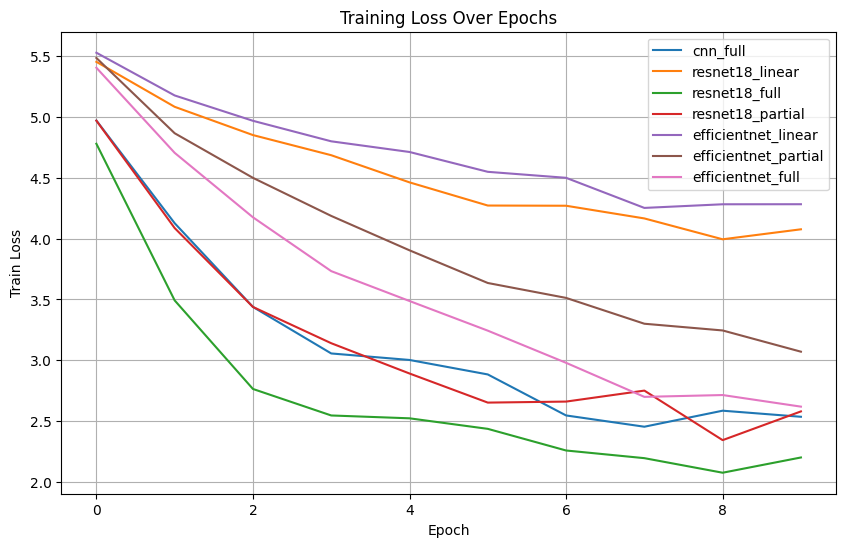

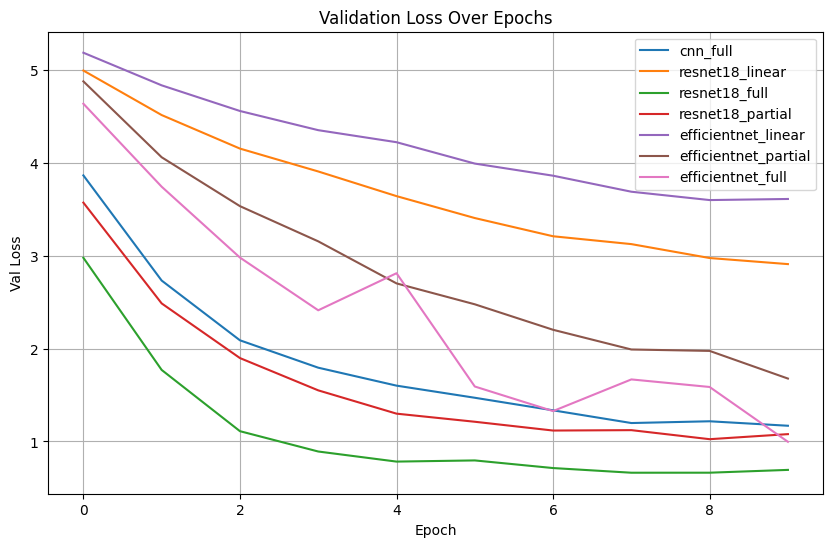

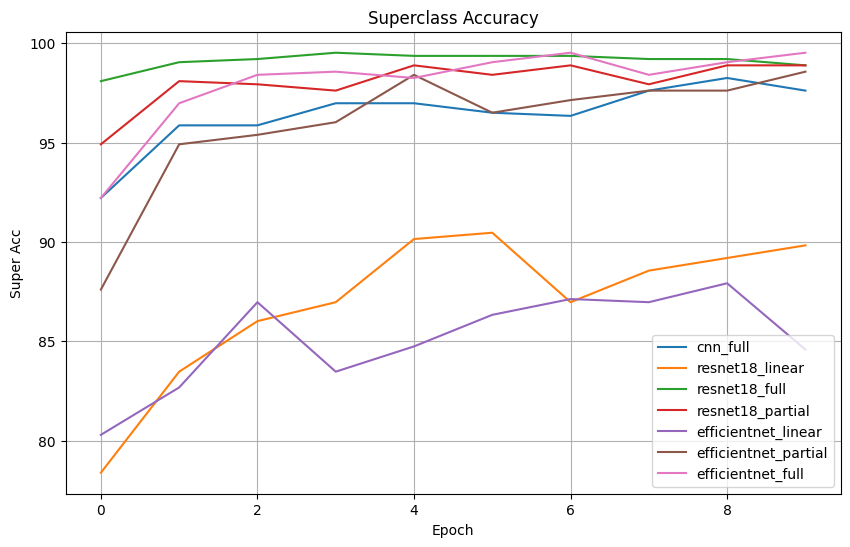

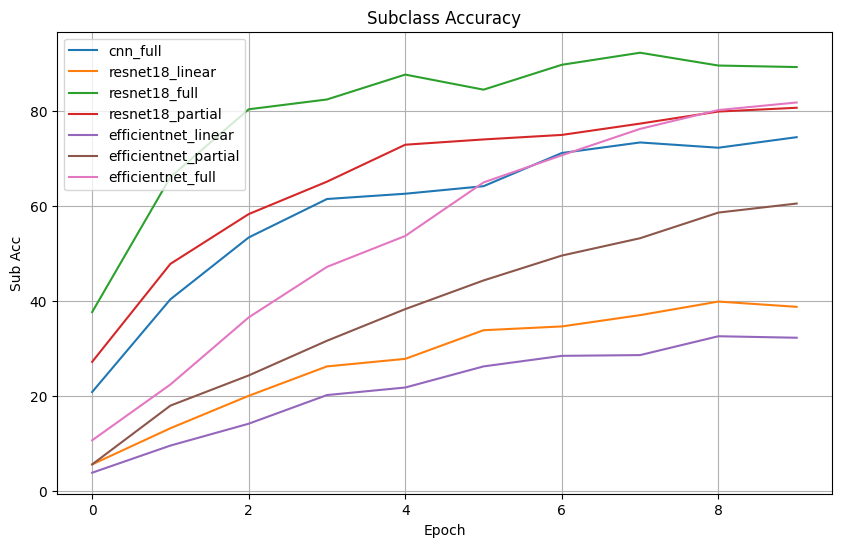

In [ ]:
import matplotlib.pyplot as plt

model_histories = {
    'cnn_full': cnn_history,
    'resnet18_linear': resnet_linear_history,
    'resnet18_full': resnet_full_history,
    'resnet18_partial': resnet_partial_history,
    'efficientnet_linear': efficientnet_linear_history,
    'efficientnet_partial': efficientnet_partial_history,
    'efficientnet_full': efficientnet_full_history
}


def plot_training_curves(histories, metric_key, title):
    plt.figure(figsize=(10, 6))
    for name, hist in histories.items():
        plt.plot(hist[metric_key], label=name)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(metric_key.replace('_', ' ').title())
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_curves(model_histories, 'train_loss', "Training Loss Over Epochs")
plot_training_curves(model_histories, 'val_loss', "Validation Loss Over Epochs")
plot_training_curves(model_histories, 'super_acc', "Superclass Accuracy")
plot_training_curves(model_histories, 'sub_acc', "Subclass Accuracy")

In [ ]:
results = []

for model_name, model in [
    ("cnn_full", cnn_model),
    ("resnet18_linear", resnet_linear),
    ("resnet18_full", resnet_full),
    ("resnet18_partial", resnet_partial),
    ("efficientnet_linear", efficientnet_linear),
    ("efficientnet_partial", efficientnet_partial),
]:
    result = validate_seen_vs_novel(model, val_loader, criterion, device)
    result['model'] = model_name
    results.append(result)

results_df = pd.DataFrame(results)
results_df.set_index('model', inplace=True)
display(results_df)


 Seen vs Novel Accuracy Report:
Seen Superclass Accuracy: 95.55%
Novel Superclass Accuracy: 0.00%
Seen Subclass Accuracy: 75.36%
Novel Subclass Accuracy: 0.00%
 Seen vs Novel Accuracy Report:
Seen Superclass Accuracy: 87.60%
Novel Superclass Accuracy: 0.00%
Seen Subclass Accuracy: 33.55%
Novel Subclass Accuracy: 0.00%
 Seen vs Novel Accuracy Report:
Seen Superclass Accuracy: 99.21%
Novel Superclass Accuracy: 0.00%
Seen Subclass Accuracy: 90.14%
Novel Subclass Accuracy: 0.00%
 Seen vs Novel Accuracy Report:
Seen Superclass Accuracy: 98.89%
Novel Superclass Accuracy: 0.00%
Seen Subclass Accuracy: 75.04%
Novel Subclass Accuracy: 0.00%
 Seen vs Novel Accuracy Report:
Seen Superclass Accuracy: 85.53%
Novel Superclass Accuracy: 0.00%
Seen Subclass Accuracy: 31.00%
Novel Subclass Accuracy: 0.00%
 Seen vs Novel Accuracy Report:
Seen Superclass Accuracy: 97.14%
Novel Superclass Accuracy: 0.00%
Seen Subclass Accuracy: 58.51%
Novel Subclass Accuracy: 0.00%


,Seen Superclass Accuracy,Novel Superclass Accuracy,Seen Subclass Accuracy,Novel Subclass Accuracy
model,,,,
cnn_full,95.548490,0.0,75.357711,0.0
resnet18_linear,87.599364,0.0,33.545310,0.0
resnet18_full,99.205087,0.0,90.143084,0.0
resnet18_partial,98.887122,0.0,75.039746,0.0
efficientnet_linear,85.532591,0.0,31.001590,0.0
efficientnet_partial,97.138315,0.0,58.505564,0.0


# Part 4: Testing

In [7]:
CONFIDENCE_THRESHOLD = 0.6
NOVEL_SUPER_IDX = 3
NOVEL_SUB_IDX = 89
from torchvision.datasets.folder import default_loader

class CustomTestDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.transform = transform
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')],
                                key=lambda x: int(x.split('.')[0]))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = default_loader(img_path)
        if self.transform:
            image = self.transform(image)
        return image, img_name
def predict_with_novelty(model, loader, device):
    model.eval()
    predictions = {
        'image': [],
        'superclass_index': [],
        'subclass_index': []
    }

    with torch.no_grad():
        for images, filenames in loader:
            images = images.to(device)
            super_logits, sub_logits = model(images)


            super_probs = F.softmax(super_logits, dim=1)
            sub_probs = F.softmax(sub_logits, dim=1)


            super_conf, super_pred = super_probs.max(dim=1)
            sub_conf, sub_pred = sub_probs.max(dim=1)


            final_super_pred = [
                p.item() if c.item() >= CONFIDENCE_THRESHOLD else NOVEL_SUPER_IDX
                for p, c in zip(super_pred, super_conf)
            ]
            final_sub_pred = [
                p.item() if c.item() >= CONFIDENCE_THRESHOLD else NOVEL_SUB_IDX
                for p, c in zip(sub_pred, sub_conf)
            ]

            predictions['image'].extend(filenames)
            predictions['superclass_index'].extend(final_super_pred)
            predictions['subclass_index'].extend(final_sub_pred)

    return pd.DataFrame(predictions)

def save_predictions_csv(df, filename='example_test_predictions.csv'):
    df.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")


test_img_dir = "/content/drive/My Drive/NNDL/test_images"
test_dataset = CustomTestDataset(test_img_dir, image_preprocessing)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def test_all_models(test_loader, device):
    model_variants = [
        ('cnn', 'full'),
        ('resnet18', 'linear'),
        ('resnet18', 'full'),
        ('resnet18', 'partial'),
        ('efficientnet', 'linear'),
        ('efficientnet', 'partial')
    ]

    for name, strategy in model_variants:
        print(f"\n Testing {name} with {strategy} fine-tuning")
        model = get_model(name, strategy)
        model.load_state_dict(torch.load(f"{name}_{strategy}_best_model.pt"))
        df = predict_with_novelty(model, test_loader, device)
        save_predictions_csv(df, filename=f"predictions_{name}_{strategy}.csv")
